In [1]:
%pip install --quiet -U langchain_groq langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

# Chain

a simple chain that combines 4 concepts:

* Using chat messages as our graph state
* Using chat models in graph nodes
* Binding tools to our chat model
* Executing tool calls in graph nodes


## Chat Messages

In [5]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

messages= [AIMessage(content= 'how can i assist you?', name='AI')]
messages.append(HumanMessage(content=f"tell me about ai.",name="Zeeshan"))
messages.append(AIMessage(content='AI refers as Artificial Intelligence. It helps computer to mimic human intelligence.',name='AI'))
messages.append(HumanMessage(content='give me types of ai', name='Zeeshan'))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: AI

how can i assist you?
================================ Human Message =================================
Name: Zeeshan

tell me about ai.
================================== Ai Message ==================================
Name: AI

AI refers as Artificial Intelligence. It helps computer to mimic human intelligence.
================================ Human Message =================================
Name: Zeeshan

give me types of ai


## Chat Models

In [2]:
from langchain_groq import ChatGroq

In [4]:
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

In [6]:
result = llm.invoke(messages)
result

AIMessage(content='There are several types of Artificial Intelligence (AI), which can be categorized based on their capabilities, functionality, and goals. Here are some of the main types of AI:\n\n1. **Narrow or Weak AI**: Designed to perform a specific task, such as facial recognition, language translation, or playing chess.\n2. **General or Strong AI**: A hypothetical AI that possesses the ability to understand, learn, and apply knowledge across a wide range of tasks, similar to human intelligence.\n3. **Superintelligence**: An AI that is significantly more intelligent than the best human minds, potentially leading to exponential growth in technological advancements.\n4. **Reactive Machines**: AI that can only react to currently existing situations, without forming memories or using past experiences to influence decisions.\n5. **Limited Memory**: AI that can learn from data and make decisions based on that data, but the learning is limited to a specific dataset or timeframe.\n6. **T

## Tools

In [7]:
def add(a: int, b: int) -> int:
  '''Multiply a and b

  Args:
  a: first int
  b: second int
  '''
  return a + b


In [8]:
llm_with_tools = llm.bind_tools([add])

In [11]:
tool_result = llm_with_tools.invoke([HumanMessage(content= '5 is added with 9' , name = 'Zeeshan')])
tool_result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ettd', 'function': {'arguments': '{"a": 5, "b": 9}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 230, 'total_tokens': 248, 'completion_time': 0.065454545, 'prompt_time': 0.013139218, 'queue_time': 0.251955337, 'total_time': 0.078593763}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_0a4b7a8df3', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c8439dfb-7a69-40fa-9288-01a97682858f-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 9}, 'id': 'call_ettd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 230, 'output_tokens': 18, 'total_tokens': 248})

In [12]:
tool_result.additional_kwargs

{'tool_calls': [{'id': 'call_ettd',
   'function': {'arguments': '{"a": 5, "b": 9}', 'name': 'add'},
   'type': 'function'}]}

## Using messages as state


In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
  messages: list[AnyMessage]

# Reducers


In [15]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
  messages : Annotated[list[AnyMessage], add_messages]

In [16]:
from langgraph.graph.message import MessagesState

class State(MessagesState):
  pass

In [17]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="what is ai?.", name="Zeeshan")
                   ]

new_message = AIMessage(content="AI refers to Artificial Intelligence.", name="Model")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b6076134-319a-4629-b514-4be4db198eac'),
 HumanMessage(content='what is ai?.', additional_kwargs={}, response_metadata={}, name='Zeeshan', id='21feba9d-bfbe-45ae-986e-ece303bf7675'),
 AIMessage(content='AI refers to Artificial Intelligence.', additional_kwargs={}, response_metadata={}, name='Model', id='a5e0124f-0658-4975-a142-9c2d28637f62')]

## Graph

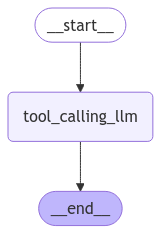

In [18]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

#Node
def tool_calling_llm(state : State):
  return {'messages': [llm_with_tools.invoke(state['messages'])]}

#Build
builder : StateGraph = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_edge(START, 'tool_calling_llm')
builder.add_edge('tool_calling_llm', END)

graph : CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

I'm here to help. How can I assist you today?


In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Add 4 and 2!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 2!
================================== Ai Message ==================================
Tool Calls:
  add (call_9z1k)
 Call ID: call_9z1k
  Args:
    a: 4
    b: 2
